# Zadanie domowe 1

W ramach zadania należało wykonać następujące zadania:
- Przygotować klasę Dataset i Dataloader używając Pytorcha dla dowolnego zbioru danych.
- Przygotować skrypt treningowy dla dowolnego modelu w Pytorch Lightning. Aby to osiągnąć należy stworzyć dwa moduły: Data Module i Lightning Module.
- Dodać model monitorujący używając wbudowanej w Pytorch Lightning funkcji dla wybranego narzędzia monitorującego, na przykład Wandb lub MLFlow.
- Walidacja modelu uczącego: Potwierdź, że model się uczy poprzez porównanie krzywych strat treningu z walidacją.
- Zaimplementuj optymalizację dla dowolnego wybranego parametru (lub grupy parametrów) używając wybranego pakietu optymalizacyjnego. (Optuna lub RayTune) 

In [16]:
from lightning.pytorch import seed_everything
seed_everything(121, workers=True)

Seed set to 121


121

## Zbiór treningowy

Obrany został zbiór treningowy z Kaggla: https://www.kaggle.com/datasets/imsparsh/flowers-dataset/

Zawiera on zdjęcia kwiatów przydzielonych do 5 kategorii:
- daisy (stokrotka)
- dandelion (mniszek)
- rose (róża)
- sunflower (słonecznik)
- tulip (tulipan)

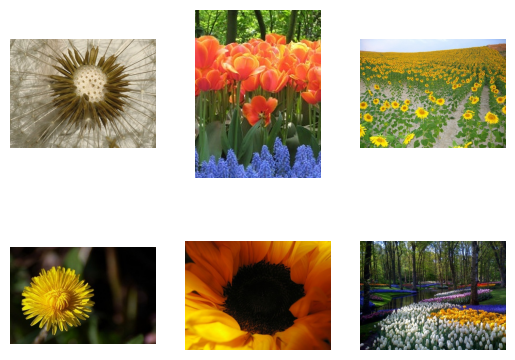

In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

path = os.path.join("Dataset", "test")
img_set = [img for img in os.listdir(path) if img.endswith('.jpg')]
img_plot = np.array([])
for i, img_path in enumerate(img_set[:6]):
    img = Image.open(os.path.join(path, img_path))
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [24]:
import torch
import lightning as L
# Główne importy i ustalenie zmiennych globalnych

RESIZE_SIZE = 128
DEFAULT_BATCH_SIZE = 16
DEFAULT_NUM_WORKERS = 4
DEFAULT_MAX_EPOCHS = 10
NUM_CLASSES = 5

In [25]:
import os
from torch.utils.data import Dataset
from PIL import Image
# Tworzenie datasetu

class ExampleDataSet(Dataset):
    def __init__(self, dataset_dir, train = True, transform = None):
        self.images = []
        self.labels = []
        self.dataset_dir = dataset_dir
        self.set_type = 'train' if train else 'test'
        self.transform = transform
        self.class_map = {}
        self.train = train
        path = os.path.join(dataset_dir, self.set_type)
        curr_class = 0
        class_dirs = sorted([cd for cd in os.listdir(path) if os.path.isdir(os.path.join(path, cd))])
        for class_dir in class_dirs:
            class_images = [img for img in os.listdir(os.path.join(path, class_dir)) if img.endswith('.jpg')]
            self.images.extend(class_images)
            self.labels.extend([class_dir] * len(class_images))
            self.class_map[class_dir] = curr_class
            curr_class += 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = os.path.join(self.dataset_dir, self.set_type, label, self.images[idx])
        label = self.class_map[label] # string -> int
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [26]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
# Tworzenie modułu Lightning Data

class LightingData(L.LightningDataModule):
    def __init__(self, dataset_dir, batch_size, num_workers, transform = transforms.ToTensor(), train_ratio = 0.8):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        training_dataset = ExampleDataSet(self.dataset_dir, train=True, transform=transform)
        train_size = int(len(training_dataset) * train_ratio)
        val_size = len(training_dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(training_dataset, [train_size, val_size])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        test_dataset = ExampleDataSet(self.dataset_dir, train=False, transform=self.transform)
        return DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

# Sieć konwolucyjna

Dane wejściowe: obraz 128x128

Liczba klas: 5

Warstwa konwolucyjna: $(3, 128, 128) \to (32, 126, 126)$

Warstwa max poolingowa: $(32, 126, 126) \to (32, 63, 63)$

Relu

Warstwa konwolucyjna: $(32, 63, 63) \to (64, 61, 61)$

Warstwa max poolingowa: $(64, 61, 61) \to (64, 30, 30)$

Relu

Flatten: $(64, 30, 30) \to (64 \cdot 30 \cdot 30, 1)$

Warstwa w pełni połączona: $(64 \cdot 30 \cdot 30) \to (150)$

Warstwa w pełni połączona: $(150) \to (5)$

In [27]:
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Dropout
from torch.nn import Sequential
from torch.nn import Flatten

def calculate_num_of_nodes(size):
    value = size - 2
    value //= 2
    value -= 2
    value //= 2
    return value*value*64

class LightingModel(L.LightningModule):
    def __init__(self, lr = 0.0002137, loss_fn = torch.nn.CrossEntropyLoss(), num_classes = NUM_CLASSES, dropout = 0.5, linear_nodes = 150):
        super().__init__()
        self.save_hyperparameters(ignore=['loss_fn', 'model'])

        self.conv1 = Conv2d(in_channels=3, out_channels=32,kernel_size=(3, 3)) 
        self.conv2 = Conv2d(in_channels=32, out_channels=64,kernel_size=(3, 3)) 
        self.maxpool = MaxPool2d(kernel_size=(2, 2)) #
        self.dropout = Dropout(dropout)
        self.linear1 = Linear(calculate_num_of_nodes(RESIZE_SIZE), linear_nodes)
        self.linear2 = Linear(linear_nodes, num_classes)

        self.num_classes = num_classes
        self.loss_fn = loss_fn
        self.lr = lr

        self.cnn = Sequential(
            self.conv1,
            self.maxpool,
            ReLU(),
            self.conv2,
            self.maxpool,
            ReLU(),
            Flatten(),
            self.linear1,
            ReLU(),
            self.dropout,
            self.linear2,
        )

    def forward(self, x):
        return self.cnn(x)
    def training_step(self, batch):
        images, targets = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, targets)
        accuracy = (outputs.argmax(dim=1) == targets).float().mean()
        self.log('val_acc', accuracy)
        self.log('val_loss', loss)

    def test_step(self, batch):
        images, targets = batch
        outputs = self(images)
        print(outputs)
        print(outputs.size())
        loss = self.loss_fn(outputs, targets)
        accuracy = (outputs.argmax(dim=1) == targets).float().mean()
        self.log('test_acc', accuracy)
        self.log('test_loss', loss)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [28]:
transform = transforms.Compose([
        transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
        transforms.ToTensor()
        ])

In [29]:
data = LightingData(
        dataset_dir = 'Dataset',
        batch_size = DEFAULT_BATCH_SIZE,
        num_workers = DEFAULT_NUM_WORKERS,
        transform = transform
    )

In [30]:
from lightning.pytorch.callbacks import ModelCheckpoint

lightning_callback = [ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='best-checkpoint'
    )]

## Model monitorujący
Wybrane zostało narzędzie Wieght & Biases

In [31]:
from lightning.pytorch.loggers import CSVLogger, WandbLogger
# Konfiguracja loggerów
csv_logger = CSVLogger("logs", name="test")
wandb_logger = WandbLogger(project="pytorch-lightning")
loggers = [csv_logger, wandb_logger]

In [32]:
model = LightingModel()

## Optymalizacja parametrów
W Pytorch Lightning można zoptymalizować parametr *learning rate* przy użyciu modułu *Tuner*.

In [ ]:
from lightning.pytorch.tuner.tuning import Tuner
tuner = Tuner(L.Trainer(max_epochs=5))

In [ ]:
lr_find = tuner.lr_find(model, train_dataloaders=data, min_lr=1e-6, max_lr=1e-1, early_stop_threshold=None)

In [ ]:
lr_find.suggestion() # XD papiesz

## Optymalizacja z użyciem optuny

Do zoptymalizowania zostały obrane dwa parametry:
- dropout - prawdopodobieństwo wyłączenia neuronów z przedziału 0.1-0.5 (zmniejsza efekt przeuczenia)
- linear_nodes - liczba neuronów w warstwie w pełni połączonej z przedziału 16-150

In [33]:
import optuna

def objective(trial):
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    linear_nodes = trial.suggest_int("linear_nodes", 16, 150)

    model = LightingModel(dropout=dropout, linear_nodes=linear_nodes)
    transform = transforms.Compose([
                transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
                transforms.ToTensor()
                ])
    datamodule = LightingData(dataset_dir='Dataset',
                            batch_size = DEFAULT_BATCH_SIZE,
                            num_workers = DEFAULT_NUM_WORKERS,
                            transform = transform)

    trainer = L.Trainer(max_epochs=5,
                        logger = True, 
                        callbacks=lightning_callback,
                        deterministic=True,
                        val_check_interval=0.2)
    hyperparameters = dict(dropout=dropout, linear_nodes=linear_nodes)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=datamodule)

    return trainer.callback_metrics['val_acc'].item()


In [34]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-03-19 09:25:25,463] A new study created in memory with name: no-name-b9774f4a-99e2-4a46-82c3-eecc883c6808
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kacper/Pulpit/Programowanie Python/NUM/checkpoints exists a

Epoch 4: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s, v_num=1]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s, v_num=1]

[I 2025-03-19 09:30:11,994] Trial 0 finished with value: 0.614545464515686 and parameters: {'dropout': 0.43862750642135395, 'linear_nodes': 33}. Best is trial 0 with value: 0.614545464515686.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 896    | train
1 | conv2   | Conv2d           | 18.5 K | train
2 | maxpool | MaxPool2d        | 0      | train
3 | dropout | Dropout          | 0      | train
4 | linear1 | Linear           | 2.8 M  | train
5 | linear2 | Linear           | 245    | train
6 | loss_fn | CrossEntropyLoss | 0      | train
7 | cnn     | Sequential       | 2.8 M  | train
-----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.138    Total estimated model params size (MB)
12        Modules in train mode
0        

Epoch 4: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s, v_num=2]

[I 2025-03-19 09:35:06,153] Trial 1 finished with value: 0.5527272820472717 and parameters: {'dropout': 0.3261746591159865, 'linear_nodes': 48}. Best is trial 0 with value: 0.614545464515686.


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 896    | train
1 | conv2   | Conv2d           | 18.5 K | train
2 | maxpool | MaxPool2d        | 0      | train
3 | dropout | Dropout          | 0      | train
4 | linear1 | Linear           | 8.4 M  | train
5 | linear2 | Linear           | 735    | train
6 | loss_fn | CrossEntropyLoss | 0      | train
7 | cnn     | Sequential       | 8.4 M  | train
-----------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.719    Total estimated model params size (MB)
12        Modules in train mode
0        

Epoch 4: 100%|██████████| 138/138 [01:02<00:00,  2.22it/s, v_num=3]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 138/138 [01:02<00:00,  2.22it/s, v_num=3]


[I 2025-03-19 09:40:31,528] Trial 2 finished with value: 0.5927272439002991 and parameters: {'dropout': 0.1145680074993404, 'linear_nodes': 146}. Best is trial 0 with value: 0.614545464515686.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 896    | train
1 | conv2   | Conv2d           | 18.5 K | train
2 | maxpool | MaxPool2d        | 0      | train
3 | dropout | Dropout          | 0      | train
4 | linear1 | Linear           | 4.4 M  | train
5 | linear2 | Linear           | 385    | train
6 | loss_fn | CrossEntropyLoss | 0      | train
7 | cnn     | Sequential       | 4.4 M  | train
--------------------------------

Epoch 4: 100%|██████████| 138/138 [00:54<00:00,  2.55it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 138/138 [00:54<00:00,  2.55it/s, v_num=4]


[I 2025-03-19 09:44:57,423] Trial 3 finished with value: 0.6090909242630005 and parameters: {'dropout': 0.4720567191651621, 'linear_nodes': 76}. Best is trial 0 with value: 0.614545464515686.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 896    | train
1 | conv2   | Conv2d           | 18.5 K | train
2 | maxpool | MaxPool2d        | 0      | train
3 | dropout | Dropout          | 0      | train
4 | linear1 | Linear           | 4.9 M  | train
5 | linear2 | Linear           | 430    | train
6 | loss_fn | CrossEntropyLoss | 0      | train
7 | cnn     | Sequential       | 4.9 M  | train
---------------------------------

Epoch 3:  25%|██▌       | 35/138 [00:14<00:42,  2.44it/s, v_num=5]         


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-03-19 09:48:07,006] Trial 4 failed with parameters: {'dropout': 0.20073939511297298, 'linear_nodes': 85} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 575, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 982, in _run
    results = self._run_stage()
  File "/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py", line 1026, in _run_stage
    self.f

NameError: name 'exit' is not defined

In [ ]:
print("Best trial:",study.best_trial)

In [ ]:
text = "Params:\n"
for key, value in study.best_trial.params.items():
    text += f" {key}: {value}, \n"
print(text)


In [11]:
trainer = L.Trainer(max_epochs = DEFAULT_MAX_EPOCHS, logger = loggers, callbacks=lightning_callback, deterministic=True, val_check_interval=0.2)
trainer.fit(model, data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kacper7866 (kacper7866-poznan-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/kacper/Pulpit/Programowanie Python/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kacper/Pulpit/Programowanie Python/NUM/checkpoints exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | conv1   | Conv2d           | 896    | train
1 | conv2   | Conv2d           | 18.5 K | train
2 | maxpool | MaxPool2d        | 0      | train
3 | dropout | Dropout          | 0      | train
4 | linear1 | Linear           | 8.6 M  | train
5 | linear2 | Linear           | 755    | train
6 | loss_fn | CrossEntropyLoss | 0      | train
7 | cnn     | Sequential       | 8.7 M  | train
-----------------------------------------------------
8.7 M     Trainable params
0         Non-trainable params
8.7 M     Total params
34.641    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s, v_num=4hlv]     

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s, v_num=4hlv]
